# CS 20 : TensorFlow for Deep Learning Research
## Lecture 03 : Linear and Logistic Regression
### Logistic Regression with tf.data

### Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

1.11.0


### Load and Pre-process data

In [2]:
(x_train, y_train), (x_tst, y_tst) = tf.keras.datasets.mnist.load_data()
x_train = (x_train  / 255)
x_train = x_train.reshape(-1, 784)
x_tst = (x_tst / 255)
x_tst = x_tst.reshape(-1, 784)

In [3]:
tr_indices = np.random.choice(range(x_train.shape[0]), size = 55000, replace = False)

x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices]

x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(55000, 784) (55000,)
(5000, 784) (5000,)


### Define the graph of Softmax Classifier

In [4]:
# hyper-par setting
epochs = 30
batch_size = 64

In [5]:
# for train
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()
print(tr_dataset)

# for validation
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()
print(val_dataset)

<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float64, tf.uint8)>
<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float64, tf.uint8)>


In [6]:
# Define Iterator
handle = tf.placeholder(dtype = tf.string)
iterator = tf.data.Iterator.from_string_handle(string_handle = handle,
                                               output_types = tr_iterator.output_types)
X, Y = iterator.get_next()
X = tf.cast(X, dtype = tf.float32)
Y = tf.cast(Y, dtype = tf.int32)

In [7]:
# create weight and bias, initialized to 0 
w = tf.get_variable(name = 'weights', shape = [784, 10], dtype = tf.float32,
                    initializer = tf.contrib.layers.xavier_initializer())
b = tf.get_variable(name = 'bias', shape = [10], dtype = tf.float32,
                    initializer = tf.zeros_initializer())
# construct model
score = tf.matmul(X, w) + b

# use the cross entropy as loss function
ce_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels = Y, logits = score))
ce_loss_summ = tf.summary.scalar(name = 'ce_loss', tensor = ce_loss) # for tensorboard

# using gradient descent with learning rate of 0.01 to minimize loss
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(ce_loss)

### Training

In [8]:
train_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/logreg_tf_data/train',
                                     graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir = '../graphs/lecture03/logreg_tf_data/val',
                                     graph = tf.get_default_graph())

In [9]:
#epochs = 30
#batch_size = 64
#total_step = int(x_tr.shape[0] / batch_size)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config = sess_config)
sess.run(tf.global_variables_initializer())
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):

    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # for mini-batch training
    sess.run([tr_iterator.initializer])
    try:
        while True:
            _, tr_loss,tr_loss_summ = sess.run(fetches = [training_op, ce_loss, ce_loss_summ],
                                               feed_dict = {handle : tr_handle})
            avg_tr_loss += tr_loss
            tr_step += 1
            
    except tf.errors.OutOfRangeError:
        pass
    
    # for validation
    sess.run([val_iterator.initializer])
    try:
        while True:
            val_loss, val_loss_summ = sess.run(fetches = [ce_loss, ce_loss_summ],
                                                          feed_dict = {handle : val_handle})
            avg_val_loss += val_loss
            val_step += 1
            
    except tf.errors.OutOfRangeError:
        pass
    
    train_writer.add_summary(tr_loss_summ, global_step = epoch)
    val_writer.add_summary(val_loss_summ, global_step = epoch)

    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if epoch % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

epoch :   0, tr_loss : 1.023, val_loss : 0.653
epoch :   5, tr_loss : 0.401, val_loss : 0.404
epoch :  10, tr_loss : 0.355, val_loss : 0.364
epoch :  15, tr_loss : 0.333, val_loss : 0.346
epoch :  20, tr_loss : 0.320, val_loss : 0.335
epoch :  25, tr_loss : 0.311, val_loss : 0.327


### Visualization

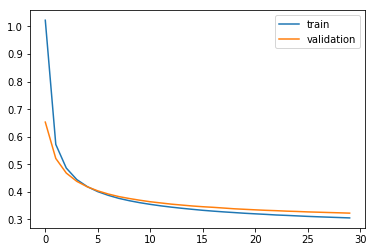

In [10]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

In [11]:
yhat = np.argmax(sess.run(score, feed_dict = {X : x_tst}), axis = 1)
print('acc : {:.2%}'.format(np.mean(yhat == y_tst)))

acc : 91.88%
